# Topological Bone Porosity Analysis
# Example Process

First load in a couple of images

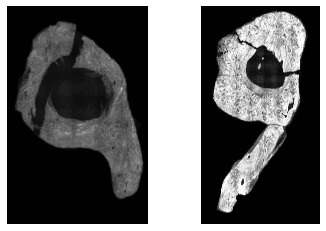

In [46]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.filters import threshold_otsu
import homcloud.interface as hc

import utils
import preprocessing_images as preprocess
import persistent_homology_SEDT as ph

path = '\\'.join(os.path.realpath("__file__").split('\\')[:-1])+"\\example\\"
filenames = ["example_SHG_1.tif", "example_SHG_2.tif"]

images=[]
for i in range(len(filenames)):
    images.append(np.array(Image.open(path+filenames[i])))

#plot the images
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(images[0], cmap="Greys_r")
ax2.imshow(images[1], cmap="Greys_r")
ax1.axis('off')
ax2.axis('off')
plt.show()

Next we want to threshold each image to binary. Here we use Ostu's thresholding technique.

Threshold: 39
Threshold: 30


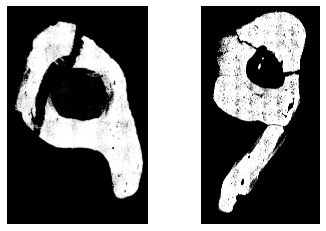

In [18]:
binary_images = []
for image in images:
    val = threshold_otsu(image)
    print(f"Threshold: {val}")
    binary_im = (image > val).astype(int)
    binary_images.append(binary_im)


#plot the images
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(binary_images[0], cmap="binary_r")
ax2.imshow(binary_images[1], cmap="binary_r")
ax1.axis('off')
ax2.axis('off')
plt.show()

 Then we're going to trim redundant background rows and columns off the binary images. 
 Next we want to take non overlapping patches of each image, here we're going to take 300 x 300 pixels square patches.
 This requires us to pad the images to integer mutliples of the patch shape, so that all patches are the same size.

In [34]:
# trim the images of border rows full of 0s (edge_val)
trimmed_binary_images = []
for binary_image in binary_images:
    trimmed_binary_images.append(preprocess.trim(binary_image, edge_val=0))

# pad the binary images and cut into 300 x 300 pixels patches
patch_shape = 300
pad_val = 0

padded_images = []
patches_per_image = []
patch_coords = []
padded_shape = []
for image in trimmed_binary_images:
    # extracts square patches size patch_size x patch_size stride apart
    padded_image, patches, coords = preprocess.extract_patches(
        image,
        patch_shape,
        pad_val=pad_val,
        stride=300)
    padded_images.append(padded_image)
    patches_per_image.append(patches)
    patch_coords.append(coords)
    padded_shape.append(padded_image.shape)

We can plot the patches for one of the images

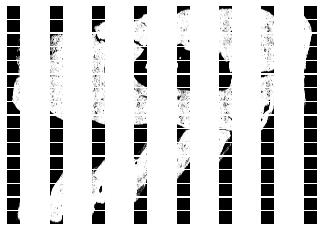

In [35]:
# plot the binary patches for the last image
rows = int(padded_shape[-1][0]/patch_shape)
cols = int(padded_shape[-1][1]/patch_shape)


fig, ax = plt.subplots(rows,cols,gridspec_kw = {'wspace':0.1, 'hspace':0.1})
for k in range(rows*cols):
    i = int(coords[k][0]/patch_shape)
    j = int(coords[k][1]/patch_shape)
    ax[i,j].imshow(patches[k], cmap="binary_r")
    ax[i,j].axis('off')


let's discard all patches that are entirely background (all 0s) for both images

In [36]:
background_val = 0 

for i in range(2):
    padded_image = padded_images[i]
    patches = patches_per_image[i]
    coords = patch_coords[i]
    shape = padded_shape[i]

    patches_to_keep = []
    patch_coords_to_keep = []
    patch_index = 0
    patches_discarded = 0
    for j in range(len(patches)):
        patch = patches[j]
        coord = coords[j]
        # how much of the patch is background?
        patch_background_percentage = np.sum(patch <= background_val)/(patch_shape*patch_shape)
        # keep patch if it's not entirely background
        if  (patch_background_percentage < 1.0):
            patches_to_keep.append(patch)
            patch_coords_to_keep.append(coord)
            patch_index +=1
        else:
            patches_discarded += 1
    print(f"image {i} completed: {patch_index} patches saved, {patches_discarded} patches discarded")
    


image 0 completed: 35 patches saved, 13 patches discarded
image 1 completed: 92 patches saved, 36 patches discarded


Perform a signed Euclidean distance transform per patch

In [38]:
SEDT_patches_per_image = []
for patches in patches_per_image:
    SEDT_image = preprocess.SEDT(patches)
    SEDT_patches_per_image.append(SEDT_image)

Let's plot the signed Euclidean distance transform of some patches

-2.8284271247461903 2.0 0


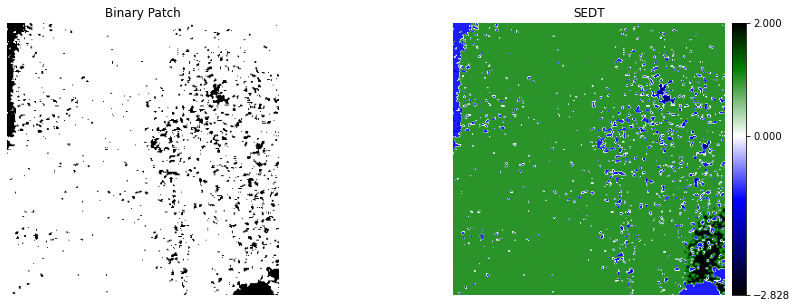

In [39]:
# play with the patch_number x
x=7

# get the patch for the first image
patch = patches_per_image[0][x]
SEDT_patch = SEDT_patches_per_image[0][x]

from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# make custom colourmap, set zero as midpoint
specific_colors = LinearSegmentedColormap.from_list('name',
    [(0,'k'),(0.3,'b'),(0.5,'w'),(0.8,'g'),(1,'k')],N=1000)
vmin, vmax, vcenter = np.min(SEDT_patch), np.max(SEDT_patch), 0
divnorm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax) 
cbar = plt.cm.ScalarMappable(norm=divnorm, cmap=specific_colors)

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.imshow(patch, cmap='binary_r')
ax1.set_title('Binary Patch')
ax1.axis('off')
im = ax2.imshow(SEDT_patch, cmap=specific_colors,norm=divnorm)
ax2.axis('off')
ax2.set_title('SEDT')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax,orientation='vertical', ticks=[vmin,0,vmax])


Calculate the persistent homology for all the patches, using the signed Euclidean distance transform.
These will need to be saved out

In [55]:
# calculate sublevel set cubical homology persistence for each image
from tqdm.auto import tqdm

intervals_per_image_patch = []
for i in tqdm(range(2),desc='image'):
        SEDT_patches = SEDT_patches_per_image[i]
        intervals_per_patch = []
        for j in tqdm(range(len(SEDT_patches)), desc='patch'):
                idiagram_filename = f"{filenames[i][:-4]}_patch{j}.idiagram"
                hc.PDList.from_bitmap_levelset(
                        SEDT_patches[j],
                        mode="sublevel",
                        type="cubical",
                        save_to=f"{path}{idiagram_filename}")
                # for dimensions 0 and 1, extract the births and deaths
                for dim in [0,1]:
                        pd = hc.PDList(path+idiagram_filename)
                        pd = pd.dth_diagram(dim)
                        # extract and save persistence intervals
                        intervals = np.vstack(
                                [pd.births, pd.deaths]
                                ).transpose()
                        ess_birth = list(pd.essential_births)
                        for i in range(len(ess_birth)):
                                intervals = np.vstack(
                                        (intervals, [ess_birth[i],np.inf])
                                        )
                        if intervals.shape[0] > 0:
                                intervals_per_patch.append(intervals)
        intervals_per_image_patch.append(intervals_per_patch)


image:   0%|          | 0/2 [00:00<?, ?it/s]

patch:   0%|          | 0/48 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
        stats.quadrant_statistics(
            intervals,
            dim,
            interval_name,
            stats_path,
            split_radius=split_radius)
    
    # combine all statistics files
    stats_df = ut.combine_stats_files(
        stats_path,
        run_path,
        "all_statistics.csv",
        logger
        )    


In [ ]:
        plots.analysis_plots(
            stats_df,
            filenames_map,
            plot_path,
            feature_cols)
        logger.info(f"Plots saved to {plot_path}")



In [ ]:
        logger.info("Classification beginning")
        svm_results = svm.classification_one_v_one(
            stats_df,
            run_path,
            logger,
            feature_cols,
            filenames_map,
            runs=runs,
            strat_col=strat_col,
            cross_val=cross_val,
            param_grid_SVC = param_grid_SVC
        )
        



In [ ]:
    path = "D:/topological-bone-analysis/example/"
    feature_cols = [
        '0_num_points',
        '0_avg_birth',
        '0_stddev_birth',
        '0_skew_birth',
        '0_percentile_25_birth',
        '0_percentile_75_birth',
        '0_iqr_birth',
        '0_avg_death',
        '0_stddev_death',
        '0_skew_death',
        '0_percentile_25_death',
        '0_percentile_75_death',
        '0_iqr_death',
        '0_pers_entropy',
        '1_num_points',
        '1_avg_birth',
        '1_stddev_birth',
        '1_skew_birth',
        '1_percentile_25_birth',
        '1_percentile_75_birth',
        '1_iqr_birth',
        '1_avg_death',
        '1_stddev_death',
        '1_skew_death',
        '1_percentile_25_death',
        '1_percentile_75_death',
        '1_iqr_death',
        '1_pers_entropy']
    filenames_map = {'example_SHG_1.tif':'group_a', 'example_SHG_2.tif':'group_b'}

    stats, results = topological_porosity_analysis(
        path,
        logger,
        preprocess.otsu_threshold,
        patch_shape=100,
        stride=100,
        save_persistence_diagrams=False,
        classification=True,
        feature_cols=feature_cols,
        filenames_map=filenames_map,
        runs=10,
        strat_col=None,
        cross_val='stratkfold',
        param_grid_SVC = {'C': [1,2,3], 'kernel': ('rbf','linear')}
    )